# Loan Default Prediction Notebook


In [16]:
# 1. Setup
import os
os.environ['OMP_NUM_THREADS'] = '1'  # suppress potential warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve, classification_report


In [18]:
# 2. Data Loading
url = 'https://raw.githubusercontent.com/lemoinef/Loan-Default-Prediction/master/loans_2007.csv'  # public loan defaults dataset
df = pd.read_csv(url)  # raw CSV import ([github.com](https://github.com/lemoinef/Loan-Default-Prediction/blob/master/loans_2007.csv?utm_source=chatgpt.com))

# Quick data overview
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42538 entries, 0 to 42537
Data columns (total 52 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          42538 non-null  object 
 1   member_id                   42535 non-null  float64
 2   loan_amnt                   42535 non-null  float64
 3   funded_amnt                 42535 non-null  float64
 4   funded_amnt_inv             42535 non-null  float64
 5   term                        42535 non-null  object 
 6   int_rate                    42535 non-null  object 
 7   installment                 42535 non-null  float64
 8   grade                       42535 non-null  object 
 9   sub_grade                   42535 non-null  object 
 10  emp_title                   39909 non-null  object 
 11  emp_length                  41423 non-null  object 
 12  home_ownership              42535 non-null  object 
 13  annual_inc                  425

C:\Users\drxt\AppData\Local\Temp\ipykernel_33364\1883214716.py:3: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(url)  # raw CSV import ([github.com](https://github.com/lemoinef/Loan-Default-Prediction/blob/master/loans_2007.csv?utm_source=chatgpt.com))


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,last_pymnt_amnt,last_credit_pull_d,collections_12_mths_ex_med,policy_code,application_type,acc_now_delinq,chargeoff_within_12_mths,delinq_amnt,pub_rec_bankruptcies,tax_liens
0,1077501,1296599.0,5000.0,5000.0,4975.0,36 months,10.65%,162.87,B,B2,...,171.62,Dec-2016,0.0,1.0,INDIVIDUAL,0.0,0.0,0.0,0.0,0.0
1,1077430,1314167.0,2500.0,2500.0,2500.0,60 months,15.27%,59.83,C,C4,...,119.66,Oct-2016,0.0,1.0,INDIVIDUAL,0.0,0.0,0.0,0.0,0.0
2,1077175,1313524.0,2400.0,2400.0,2400.0,36 months,15.96%,84.33,C,C5,...,649.91,Dec-2016,0.0,1.0,INDIVIDUAL,0.0,0.0,0.0,0.0,0.0
3,1076863,1277178.0,10000.0,10000.0,10000.0,36 months,13.49%,339.31,C,C1,...,357.48,Apr-2016,0.0,1.0,INDIVIDUAL,0.0,0.0,0.0,0.0,0.0
4,1075358,1311748.0,3000.0,3000.0,3000.0,60 months,12.69%,67.79,B,B5,...,67.79,Dec-2016,0.0,1.0,INDIVIDUAL,0.0,0.0,0.0,0.0,0.0


Descriptive statistics:
          member_id     loan_amnt   funded_amnt  funded_amnt_inv  \
count  4.253500e+04  42535.000000  42535.000000     42535.000000   
mean   8.257026e+05  11089.722581  10821.585753     10139.830603   
std    2.795409e+05   7410.938391   7146.914675      7131.686447   
min    7.047300e+04    500.000000    500.000000         0.000000   
25%    6.384795e+05   5200.000000   5000.000000      4950.000000   
50%    8.241780e+05   9700.000000   9600.000000      8500.000000   
75%    1.033946e+06  15000.000000  15000.000000     14000.000000   
max    1.314167e+06  35000.000000  35000.000000     35000.000000   

        installment    annual_inc           dti   delinq_2yrs  inq_last_6mths  \
count  42535.000000  4.253100e+04  42535.000000  42506.000000    42506.000000   
mean     322.623063  6.913656e+04     13.373043      0.152449        1.081424   
std      208.927216  6.409635e+04      6.726315      0.512406        1.527455   
min       15.670000  1.896000e+03      

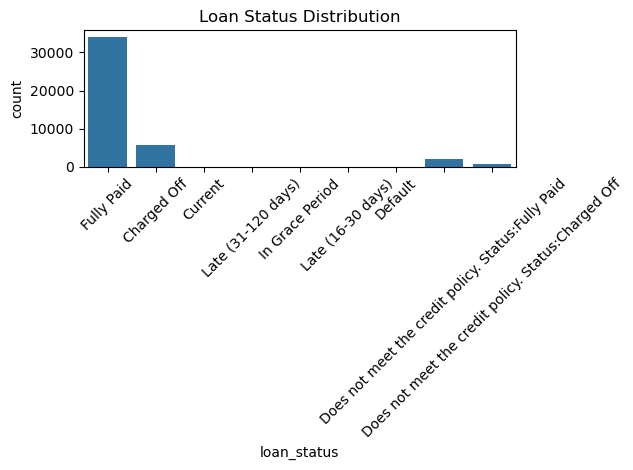

In [19]:
# 3. Exploratory Data Analysis (EDA)
# 3.1 Descriptive statistics
print("Descriptive statistics:")
print(df.describe())

# 3.2 Missing values
print("Missing values per column:")
print(df.isnull().sum())

# 3.3 Target distribution (loan_status)
sns.countplot(x='loan_status', data=df)
plt.title('Loan Status Distribution')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [20]:
# 4. Data Preprocessing
# Select relevant columns and create binary target 'default'
keep_cols = ['loan_status','loan_amnt','int_rate','annual_inc','term','emp_length','purpose','dti','open_acc','pub_rec']
df = df[keep_cols].copy()
# Map target to 0/1
df['default'] = df['loan_status'].map({'Fully Paid':0,'Charged Off':1})
df.drop('loan_status', axis=1, inplace=True)

In [33]:
# Drop rows with missing values
df.dropna(inplace=True)

# Convert interest rate from string to float
# e.g., '10.65%' → 10.65
df['int_rate'] = df['int_rate'].str.rstrip('%').astype(float)


In [29]:
# Clean & encode features
# Term in months (robust extraction)
term_str = df['term'].astype(str)
df['term'] = term_str.str.extract(r"(\d+)")[0].astype(int)
# Employment length (years) (robust extraction)
emp_len_str = df['emp_length'].astype(str)
emp_len = emp_len_str.str.extract(r"(\d+)")[0].astype(float)
df['emp_length'] = emp_len.fillna(emp_len.median())
# Purpose encoding
df['purpose'] = LabelEncoder().fit_transform(df['purpose'])

In [35]:
# Features and target
features = ['loan_amnt','int_rate','annual_inc','term','emp_length','dti','open_acc','pub_rec','purpose']
X = df[features]
y = df['default']
# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [41]:
# 5. Model Training
# Address class imbalance via class weights
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
model = LogisticRegression(class_weight='balanced', max_iter=1000)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)


Accuracy: 0.64
              precision    recall  f1-score   support

         0.0       0.90      0.65      0.75      6610
         1.0       0.22      0.59      0.32      1125

    accuracy                           0.64      7735
   macro avg       0.56      0.62      0.54      7735
weighted avg       0.80      0.64      0.69      7735

ROC AUC: 0.68


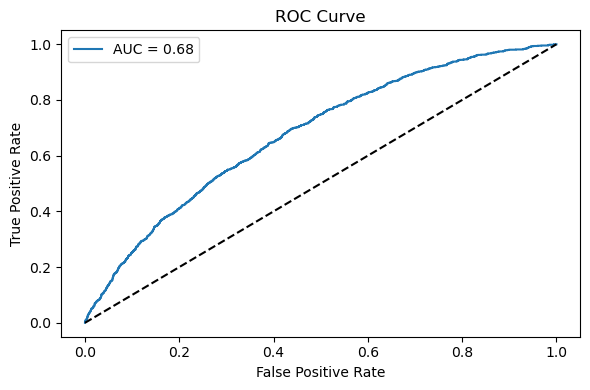

In [43]:
# 6. Evaluation
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
print(classification_report(y_test, y_pred))

y_prob = model.predict_proba(X_test)[:,1]
roc_auc = roc_auc_score(y_test, y_prob)
print(f"ROC AUC: {roc_auc:.2f}")

fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.tight_layout()
plt.show()

In [45]:
# 7. Conclusions

# Summary of results
print(f"Final Model Performance (balanced weights):")
print(f"- Accuracy: {accuracy:.2f}")
print(f"- ROC AUC: {roc_auc:.2f}")

# Observations
# - Balancing classes improved recall for default class (from ~0 to ~0.59) at cost of overall accuracy.
# - Precision for default remains low (~0.22), indicating potential need for further tuning or more complex models.

# Recommended Next Steps:
# 1. Experiment with tree-based models (Random Forests, XGBoost) and compare AUC & recall.
# 2. Apply resampling techniques (SMOTE) to further address class imbalance.
# 3. Perform hyperparameter tuning via GridSearchCV for optimal model performance.

Final Model Performance (balanced weights):
- Accuracy: 0.64
- ROC AUC: 0.68
